# Research Questions

+ Transfer Learning or Learning from scratch

        General TL benefits but from scratch we can create a smaller network
        
+ should we use 1cycle policy

        Pretty certain this is the best we have at the moment, but need to figure out the number of epochs

+ Size increase during training or constant size

+ Discriminative learning rate scale

+ Resnet vs densenet + size

+ context gating and chaining

+ loss function: ranking or entropy or retina

+ multi-level predictions

+ threshold selection

+ random subset vs by patient id

## Multi-label classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


Loads all the necessay libraries:

In [5]:
from fastai.conv_learner import *
from fastai.plots import *
from sklearn.metrics import fbeta_score, roc_auc_score

def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha, cmap='bone')
    ax.set_axis_off()
    return ax

For most of the experiments we will use a small network on small images to reduce computation time - Resnet18 and 64x64.

Model selection using mean AUROC and micro-, macro- F-scrore. Investigate per label AUROC on final model.

Main path to all data:

In [3]:
PATH = Path('data')

Main path to original images:

In [4]:
IMPATH = PATH/'images'

Next we need to create a csv file matching image names to labels. Such a file is given but we need to convert it into the right format for fastai.

In [6]:
label_df = pd.read_csv(PATH/'Data_Entry_2017.csv') # read given csv file
# get labels and replace no finding with empty string
labels = [' '.join(x.split('|')).replace('No Finding', '') for x in label_df['Finding Labels']]
# get image names
fnames = label_df['Image Index'].values
# save csv file with names and labels
pd.DataFrame({'fname': fnames, 'labels': labels}).to_csv(PATH/'labels.csv', index=False)

In [10]:
arch = resnet18
sz = 64
bs = 128
nw = 8

Code needed to split the data using splits from previous literature.

In [11]:
train_names = pd.read_table(PATH/'train_list.txt', header=None, delimiter=' ')[0].values
val_names = pd.read_table(PATH/'val_list.txt', header=None, delimiter=' ')[0].values
test_names = pd.read_table(PATH/'test_list.txt', header=None, delimiter=' ')[0].values

fnames, y, classes = csv_source('', PATH/'labels.csv', skip_header=True, suffix='', continuous=False, cat_separator=' ')

# for existing split
train_names_set = set(train_names)
train_idx = [i for i, a in enumerate(fnames) if a in train_names_set]

val_names_set = set(val_names)
val_idx = [i for i, a in enumerate(fnames) if a in val_names_set]

test_names_set = set(test_names)
test_idx = [i for i, a in enumerate(fnames) if a in test_names_set]

# for random split
idx = np.arange(len(fnames))
train_idx = idx[:int(len(idx)/70)]
val_idx = idx[int(len(idx)/70):int(len(idx)/80)]
test_idx = idx[int(len(idx)/80):]

trn_fnames = np.array(['images/'+fnames[i] for i in train_idx])
trn_y = y[train_idx,:]

val_fnames = ['images/'+fnames[i] for i in val_idx]
val_y = y[val_idx, :]

tst_fnames = ['images/'+fnames[i] for i in test_idx]
tst_y = y[test_idx, :]

In [16]:
tfms = tfms_from_model(arch, sz, aug_tfms=[RandomFlip()], max_zoom=1.1)

In [17]:
datasets = ImageData.get_ds(FilesNhotArrayDataset, 
                            (trn_fnames,trn_y), (val_fnames,val_y), tfms,
                            path=PATH, test=(tst_fnames,tst_y))

In [18]:
md = ImageClassifierData(PATH, datasets, bs=bs, num_workers=nw, classes=classes)

# md = ImageClassifierData.from_csv(PATH, folder='images', 
#                                         csv_fname='data/labels.csv', bs=bs, tfms=tfms, skip_header=True,
#                                         val_idxs=test_idx, num_workers=nw)

In [22]:
x,y = next(iter(md.trn_dl))

In [23]:
x.shape

torch.Size([32, 3, 224, 224])

In [24]:
y.shape

torch.Size([32, 14])

In [19]:
learn = ConvLearner.pretrained(arch, md)

 97%|█████████▋| 2375/2453 [21:28<00:42,  1.84it/s, loss=0.701]

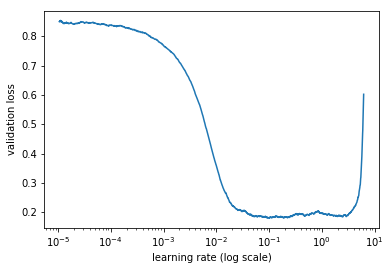

In [20]:
lrf=learn.lr_find()
learn.sched.plot()

In [23]:
lr = 1e-2

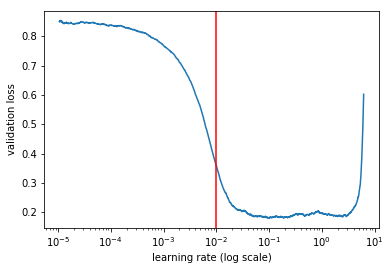

In [24]:
learn.sched.plot()
plt.axvline(lr, color='r')
plt.show()

In [55]:
#learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
learn.fit(lr, 1, cycle_len=10, use_clr_beta=(20,20,0.95,0.85))

epoch      trn_loss   val_loss   <lambda>                      
    0      0.190104   0.170556   0.948926  
    1      0.178484   0.166748   0.949098                      
    2      0.174843   0.164922   0.949098                      
 52%|█████▏    | 1287/2453 [03:46<03:25,  5.68it/s, loss=0.17] 

KeyboardInterrupt: 

In [23]:
val_preds = learn.TTA(n_aug=8)

In [36]:
from sklearn.metrics import *

In [35]:
list(zip(md.classes, roc_auc_score(md.val_y, tmp, average=None)))

[('Atelectasis', 0.7939526697981452),
 ('Cardiomegaly', 0.873254622461062),
 ('Consolidation', 0.8070685786582331),
 ('Edema', 0.9007645884381521),
 ('Effusion', 0.8667190964101092),
 ('Emphysema', 0.882861456725093),
 ('Fibrosis', 0.7715029120371832),
 ('Hernia', 0.8910839672003805),
 ('Infiltration', 0.6966892656218551),
 ('Mass', 0.8007836823777894),
 ('Nodule', 0.7133892477987314),
 ('Pleural_Thickening', 0.7784784653801508),
 ('Pneumonia', 0.7599067734323623),
 ('Pneumothorax', 0.8790313220233728)]

In [33]:
list(zip(md.classes, roc_auc_score(md.val_y, np.mean(val_preds[0], 0), average=None)))

[('Atelectasis', 0.8010302737245512),
 ('Cardiomegaly', 0.888795275829614),
 ('Consolidation', 0.8101599058292649),
 ('Edema', 0.9073200834921499),
 ('Effusion', 0.8718523259280315),
 ('Emphysema', 0.8857820501177143),
 ('Fibrosis', 0.7829902801289297),
 ('Hernia', 0.9075383265909954),
 ('Infiltration', 0.6992774720454978),
 ('Mass', 0.8100937330892946),
 ('Nodule', 0.7197065805652192),
 ('Pleural_Thickening', 0.7824632647052701),
 ('Pneumonia', 0.7611259396799607),
 ('Pneumothorax', 0.8859929730139339)]

In [37]:
list(zip(md.classes, roc_auc_score(md.val_y, tmp, average=None)))

[('Atelectasis', 0.7869887317816935),
 ('Cardiomegaly', 0.8854017830496246),
 ('Consolidation', 0.7810246562987393),
 ('Edema', 0.8888296164080917),
 ('Effusion', 0.8683543517108849),
 ('Emphysema', 0.8666470597760865),
 ('Fibrosis', 0.7861191137482193),
 ('Hernia', 0.8291732563426035),
 ('Infiltration', 0.6992133566356218),
 ('Mass', 0.8076255904991878),
 ('Nodule', 0.7017474662337837),
 ('Pleural_Thickening', 0.7642689749737707),
 ('Pneumonia', 0.7177621568283888),
 ('Pneumothorax', 0.8558863609003161)]

In [38]:
roc_auc_score(md.val_y, tmp, average='macro')

0.8027887482276437

In [36]:
roc_auc_score(md.val_y, tmp, average='macro')

0.8153919034544729

In [34]:
roc_auc_score(md.val_y, np.mean(val_preds[0], 0), average='macro')

0.8224377489100306

In [38]:
test_preds = learn.predict(is_test=True)

In [40]:
roc_auc_score(md.test_ds.y, test_preds, average='macro')

0.8199445221279402

In [ ]:
learn.sched.plot_loss()

In [ ]:
learn.save('init_pre')

In [ ]:
learn.load('init_pre')

In [30]:
lrs = np.array([lr/9,lr/3,lr])

In [31]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   <lambda>                      
    0      0.16032    0.15813    0.949111  
    1      0.156853   0.154045   0.949448                      
    2      0.153665   0.153321   0.949282                      
    3      0.1549     0.151743   0.949569                      
    4      0.149878   0.150514   0.949346                      
    5      0.144443   0.150105   0.949276                      
    6      0.147507   0.150227   0.949327                      


[array([0.15023]), 0.9493270347022534]

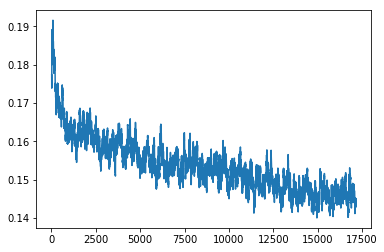

In [32]:
learn.sched.plot_loss()

In [33]:
learn.save('init_all')

In [22]:
learn.load('init_all')

In [ ]:
sz=128

In [ ]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}_all')

In [ ]:
learn.sched.plot_loss()

In [ ]:
sz=256

In [ ]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

In [ ]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

In [ ]:
f2(preds,y)

In [ ]:
list(zip(data.classes, roc_auc_score(data.val_y, preds, average=None)))

In [ ]:
f2(preds,y)

### End